- loss function defined by measure of entropy in residuals
- nudge all CNMF parameters within a window, see which direction reduces loss function, numerically determined gradient
    - allow some params to be nudged as floats, some as ints, and a diff minimum nudge window for each


In [1]:
import caiman as cm
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf.params import CNMFParams
import numpy as np
from pathlib import Path
from fastplotlib import Plot, GridPlot, Image
from ipywidgets import IntSlider, VBox, Textarea
from skimage.measure import shannon_entropy
from tqdm import tqdm
from matplotlib import pyplot as plt
from time import sleep
from fastplotlib.utils import quick_min_max
from typing import *

2022-09-18 02:45:49.130066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 02:45:49.522468: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-18 02:45:50.281625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kushal/python-venvs/torch-mesmerize/lib/python3.10/site-packages/cv2/../../lib64:/opt/cuda/lib64/:
2022-09-18 02:45:50.281793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load 

In [10]:
from mesmerize_core import *

In [11]:
df = load_batch("/home/kushal/caiman_data/mesmerize-core-batch/batch2.pickle")

In [14]:
df.iloc[-1]

algo                                                             cnmf
item_name                                                    my_movie
input_movie_path    05b2c380-541c-4d8a-b04f-38ef60bbd9af/05b2c380-...
params              {'main': {'p': 1, 'gnb': 2, 'merge_thr': 0.85,...
outputs             {'mean-projection-path': 08f4982c-1c2e-4ad4-9d...
comments                                                         None
uuid                             08f4982c-1c2e-4ad4-9d56-8bae2e366d97
Name: 2, dtype: object

In [22]:
cnmf_params =\
{
    'p': 1,
    'gnb': 2,
    # raises error: no parameter 'merge_thresh' found
    'merge_thr': 0.85,
    'rf': 15,
    'stride_cnmf': 6,
    'K': 4,
    'gSig': [4, 4],
    'ssub': 1,
    'tsub': 1,
    'method_init': 'greedy_roi',
    'min_SNR': 2.0,
    'rval_thr': 0.7,
    'use_cnn': True,
    'min_cnn_thr': 0.8,
    'cnn_lowest': 0.1,
    'decay_time': 0.4,
}

In [23]:
cnmf_params = CNMFParams(params_dict=cnmf_params)

In [4]:
c, dview, n_processes = cm.cluster.setup_cluster(
    backend="local", 
    n_processes=22, 
    single_thread=False
)

Process ForkPoolWorker-18:
Process ForkPoolWorker-20:
Process ForkPoolWorker-3:
Process ForkPoolWorker-22:
Process ForkPoolWorker-21:
Process ForkPoolWorker-13:
Process ForkPoolWorker-7:
Process ForkPoolWorker-17:
Process ForkPoolWorker-11:
Process ForkPoolWorker-16:
Process ForkPoolWorker-19:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-8:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiproces

In [5]:
input_movie = "/home/kushal/caiman_data/example_movies/Sue_2x_3000_40_-46.tif"
memmap_path = cm.save_memmap([input_movie], base_name="cnmf-memmap", order="C", dview=dview)

In [6]:
memmap_path = "/home/kushal/caiman_data/example_movies/cnmf-memmap_d1_170_d2_170_d3_1_order_C_frames_3000_.mmap"

In [26]:
memmap_path = "/home/kushal/caiman_data/mesmerize-core-batch/08f4982c-1c2e-4ad4-9d56-8bae2e366d97/08f4982c-1c2e-4ad4-9d56-8bae2e366d97_cnmf-memmap__d1_170_d2_170_d3_1_order_C_frames_3000_.mmap"

In [27]:
Yr, dims, T = cm.load_memmap(memmap_path)
images = np.reshape(Yr.T, [T] + list(dims), order="F")

In [28]:
cnm = cnmf.CNMF(
    20,
    params=cnmf_params,
    dview=dview,
    deconv_flag=False
)

In [29]:
cnm.fit(images)
cnm.refit(images)

In [30]:
def get_rcm_bg_resid(Y: np.ndarray, c: cnmf.CNMF, index: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    rcm = c.estimates.A.dot(c.estimates.C[:, index]).reshape(c.dims + (-1,), order="F").transpose([2, 0, 1])[0]
    bg = c.estimates.b.dot(c.estimates.f[:, index]).reshape(c.dims + (-1,), order="F").transpose([2, 0, 1])[0]
    resid = Y[index] - rcm - bg
    return rcm, bg, resid

In [321]:
rcm, bg, resid = get_rcm_bg_resid(images, cnm, 0)

# gridplot with 1 row, 2 columns
gp_rcm = GridPlot(
    shape=(2, 2),
    controllers="sync"
)

# for the mcorr movie
left_graphic = Image(
    data=images[0].T, # image data for the first frame
    cmap='gnuplot2' # my favorite colormap
)

# create the graphic
right_graphic = Image(
    data=rcm.T, # image data for the first frame
    # vmin=10,
    # vmax=100,
    cmap='gnuplot2'
)

# residuals
resid_graphic = Image(
    data=resid,
    cmap="gnuplot2",
)

# reconstructed background, b * f
recon_bg_graphic = Image(
    data=bg,
    cmap="gnuplot2",
)


# add the grahpics to the subplots
gp_rcm.subplots[0, 0].add_graphic(left_graphic)
gp_rcm.subplots[0, 1].add_graphic(right_graphic)
gp_rcm.subplots[1, 0].add_graphic(resid_graphic)
gp_rcm.subplots[1, 1].add_graphic(recon_bg_graphic)

# make a GUI slider
slider_rcm = IntSlider(value=0, min=0, max=images.shape[1] - 1, step=1)

previous_value = 0

# a function to update the frame based on the slider value
def update_rcm_frame():
    global previous_value
    if previous_value == slider_rcm.value:
        return
    
    left_graphic.update_data(images[slider_rcm.value].T)
    
    rcm, bg, resid = get_rcm_bg_resid(images, cnm, slider_rcm.value)
    # get the A x C for just 1 frame
    right_graphic.update_data(rcm.T)
    
    # residuals for 1 frame
    resid_graphic.update_data(resid)
    
    # b * f for 1 frame
    recon_bg_graphic.update_data(bg)
    
    previous_value = slider_rcm.value
    
# add to the animation so that this is run in every render cycle
gp_rcm.add_animations([update_rcm_frame])
VBox([gp_rcm.show(), slider_rcm])


RFBOutputContext()

In [32]:
rcm = cnm.estimates.A.dot(cnm.estimates.C).reshape(cnm.dims + (-1,), order="F").transpose([2, 0, 1])
bg = cnm.estimates.b.dot(cnm.estimates.f).reshape(cnm.dims + (-1,), order="F").transpose([2, 0, 1])
resid = images - rcm - bg

In [33]:
rcm.shape

(3000, 170, 170)

In [34]:
bg.shape

(3000, 170, 170)

In [35]:
resid.shape

(3000, 170, 170)

In [36]:
images.shape

(3000, 170, 170)

In [37]:
shannon_entropy_vec = np.vectorize(shannon_entropy, signature="(n, m) -> ()")

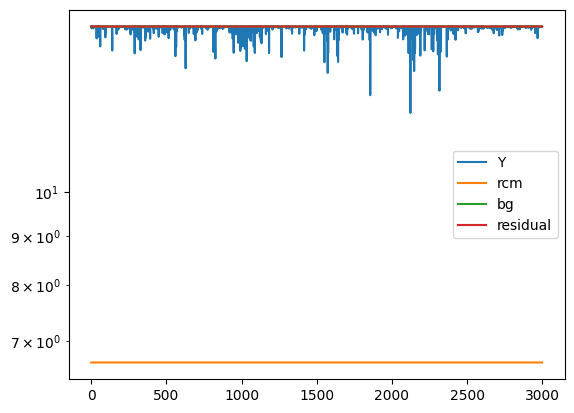

In [38]:
plt.plot(shannon_entropy_vec(images), label="Y")
plt.plot(shannon_entropy_vec(rcm), label="rcm")
plt.plot(shannon_entropy_vec(bg), label="bg")
plt.plot(shannon_entropy_vec(resid), label="residual")
plt.yscale("log")
plt.legend()

In [40]:
shannon_entropy_vec(resid).mean()

14.818781849207348

In [41]:
shannon_entropy_vec(resid)

array([14.81878187, 14.81878187, 14.81878187, ..., 14.81878187,
       14.81878187, 14.81878187])

In [51]:
shannon_entropy(rcm[2000])

6.655060405573653

# Loss function

In [308]:
from skimage.feature import graycomatrix, greycoprops, structure_tensor

In [309]:
def glcm_entropy(a):
    g = feature.graycomatrix(
        a.astype(np.uint8), 
        distances=[2, 4, 8], 
        angles=[0, 45, 90, 135, 270], 
        levels=256, 
        symmetric=True, 
        normed=True
    )
    
    return -np.sum(g * np.log2(g + (g==0)))

In [310]:
glcm_entropy(rcm[0])

59.35733102782228

In [311]:
glcm_e_vec = np.vectorize(glcm_entropy, signature="(n, m) -> ()")

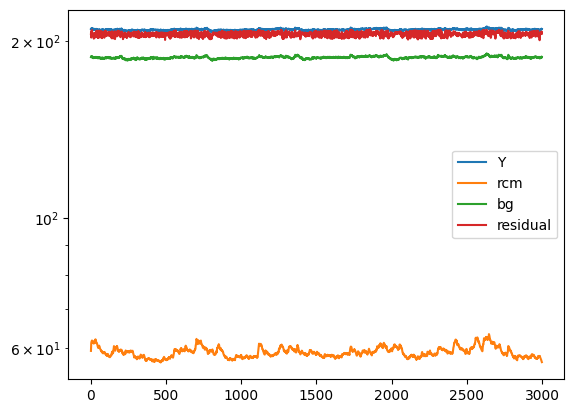

In [312]:
plt.plot(glcm_e_vec(images), label="Y")
plt.plot(glcm_e_vec(rcm), label="rcm")
plt.plot(glcm_e_vec(bg), label="bg")
plt.plot(glcm_e_vec(resid), label="residual")
plt.yscale("log")
plt.legend()

# Minimize (1 / entropy(residuals))

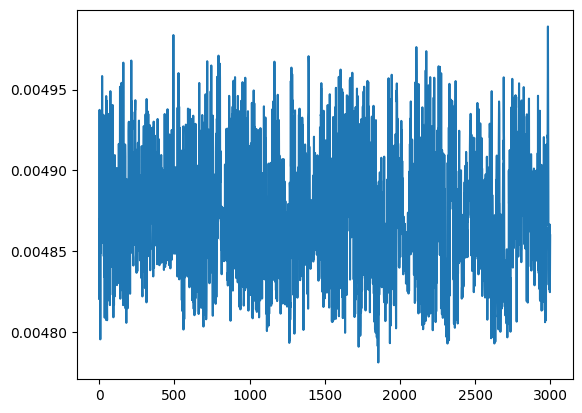

In [313]:
plt.plot(1 / glcm_e_vec(resid))

In [319]:
norm = np.vectorize(np.linalg.norm, signature="(n, m) -> ()")

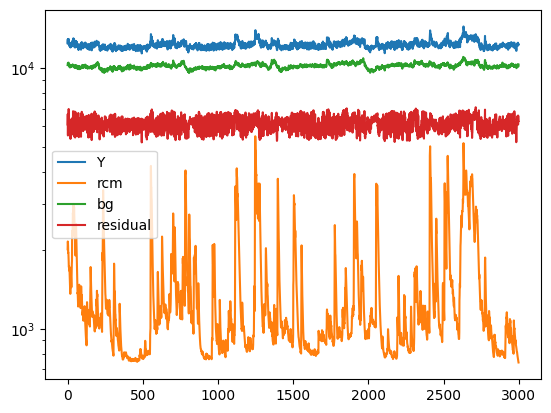

In [320]:
plt.plot(norm(images), label="Y")
plt.plot(norm(rcm), label="rcm")
plt.plot(norm(bg), label="bg")
plt.plot(norm(resid), label="residual")
plt.yscale("log")
plt.legend()